# Load the CSV file into a Pandas DataFrame

In [1]:
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import numpy as np
essay_ids = range(1,7)
threshold=1
data_path = "asap-aes/"
org = pd.read_excel(data_path+"training_set_rel3.xlsx")
domains = ['domain1', 'domain2']

In [2]:
def read_set(essay_id):
    df = pd.read_csv(data_path+"results_gemini/EssaySet"+str(essay_id)+"_assessment_results_by_rubric.csv")
    if essay_id==1:
        df['domain1_score']= df['domain1_score']//2
        df['domain1_score'].head(5)
    return df

In [6]:
df_results = pd.DataFrame(columns=['Essay Set', 'No.Instances','Mean', 'Min', 'Max', 'No.Instances_gemini','Mean_gemini', 'Min_gemini', 'Max_gemini' ])
# Loop over each CSV file and read the DataFrame from the file
for i in essay_ids:
    df_org = org[org['essay_set'] == i]
    df_gemini = read_set(essay_id=i)
    if 'domain1_Point_gemini' in df_gemini.columns:
        df_gemini['domain1_Score_gemini'] = df_gemini['domain1_Score_gemini'].fillna(df_gemini['domain1_Point_gemini'])
    for domain in domains:
        if (domain+'_score' in df_gemini.columns):
            score_org = df_org[[domain+'_score']]

            score_gemini = df_gemini[[domain+'_Score_gemini']]    
            # Calculate the mean, max, and count
            min = score_org.min()[0]
            mean = score_org.mean()[0].round(2)
            max = score_org.max()[0]
            count = score_org.count()[0]
            min1 = score_gemini.min()[0]
            mean1 = score_gemini.mean()[0].round(2)
            max1 = score_gemini.max()[0]
            count1 = score_gemini.count()[0]
            # Add the results to the DataFrame
            df_results.loc[str(i)+str(domain)] = [f'EssaySet {i}: {domain}', count,mean, min, max, count1,mean1, min1, max1]
df_results.to_csv(data_path+"reports_graphs_gemini/Report for EssaySets.csv", index=False)
df_results.to_excel(data_path+"reports_graphs_gemini/Report for EssaySets.xlsx", index=False)
# Print the results
df_results.head(8)

C:\Users\Nimra\AppData\Local\Temp\ipykernel_15264\3931122285.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min = score_org.min()[0]
C:\Users\Nimra\AppData\Local\Temp\ipykernel_15264\3931122285.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = score_org.mean()[0].round(2)
C:\Users\Nimra\AppData\Local\Temp\ipykernel_15264\3931122285.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max = score_org.max()[0]
C:\Users

,Essay Set,No.Instances,Mean,Min,Max,No.Instances_gemini,Mean_gemini,Min_gemini,Max_gemini
1domain1,EssaySet 1: domain1,1783,8.53,2.0,12.0,1685,2.18,1.0,5.0
2domain1,EssaySet 2: domain1,1800,3.42,1.0,6.0,1525,3.55,1.0,5.0
2domain2,EssaySet 2: domain2,1800,3.33,1.0,4.0,1524,2.48,1.0,4.0
3domain1,EssaySet 3: domain1,1726,1.85,0.0,3.0,1544,1.56,0.0,3.0
4domain1,EssaySet 4: domain1,1771,1.43,0.0,3.0,1558,1.42,0.0,8.0
5domain1,EssaySet 5: domain1,1805,2.41,0.0,4.0,1277,2.06,0.0,4.0
6domain1,EssaySet 6: domain1,1800,2.72,0.0,4.0,1320,2.64,0.0,4.0


# print deviations

In [8]:
for essay_id in essay_ids:
    df = read_set(essay_id)
    # Calculate the difference between the actual and predicted scores
    for domain in domains:
        if (domain+'_Score_gemini' in df.columns):
            if 'domain1_Point_gemini' in df.columns:
                df['domain1_Score_gemini'] = df['domain1_Score_gemini'].fillna(df['domain1_Point_gemini'])
            df.dropna(subset=[domain+'_Score_gemini'], inplace=True)
            df[domain+ 'Difference'] = abs(df[domain+'_score'] - df[domain+'_Score_gemini'])
            print(f"Essayset{essay_id} {domain} has {len(df[domain+ 'Difference'])} instances" )
            # Filter the DataFrame to only include rows where the difference is greater than 10
            deviations = df[df[domain+'Difference'] > threshold]
            # print("\t"+str(round(len(deviations)/len(df)*100)) + f"% results are daviating for {domain} and the count is: " +str(len(deviations)))
            # Print the rows where the difference is greater than 10
    deviations.to_csv(data_path+"reports_graphs_gemini/EssaySet"+str(essay_id)+"_deviations.csv", index=False)

Essayset1 domain1 has 1685 instances
Essayset2 domain1 has 1525 instances
Essayset2 domain2 has 1524 instances
Essayset3 domain1 has 1544 instances
Essayset4 domain1 has 1558 instances
Essayset5 domain1 has 1277 instances
Essayset6 domain1 has 1320 instances


# Plot pie graphs

In [9]:
# Define a function that creates a pie chart of essay scores and returns the subplot
def create_pie_chart(title, scores, graph_path):
    # Create a figure with three subplots
    cmap_actual = plt.get_cmap('Pastel1')
    counts = scores.value_counts()
    labels = counts.index
    # labels = ['4', '3', '2', '1']
    values = counts.values
    explode = [0.2 if c < 20 else 0 for c in values]
    cmap_actual = plt.get_cmap('Pastel1')
    plt.figure(figsize=(5,4))
    plt.pie(values, labels=labels, autopct='%1.1f%%', explode=explode, colors=cmap_actual(range(len(labels))),
                              shadow = True, 
                              wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
       textprops={'size': 12})
    plt.title(title,fontsize=10)
    plt.legend()
    plt.axis('equal')
    plt.legend()
    # Adjust the plot layout to prevent labels from overlapping with the border
    plt.tight_layout()
    plt.savefig(graph_path+"line.png")
    plt.show()

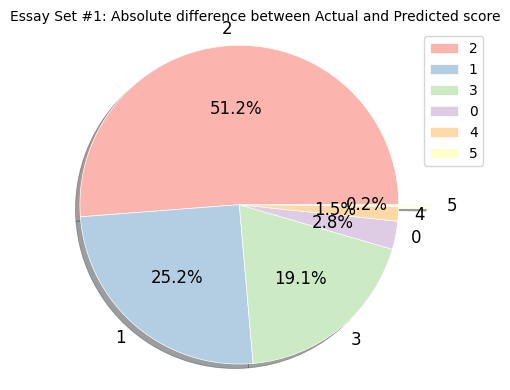

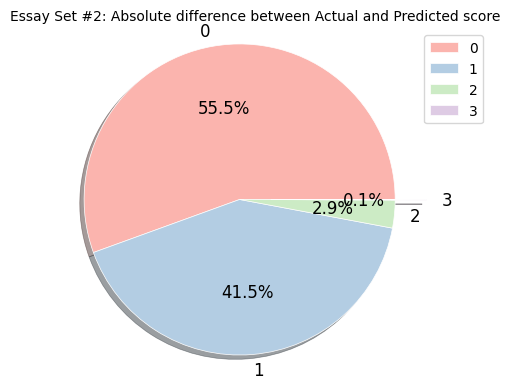

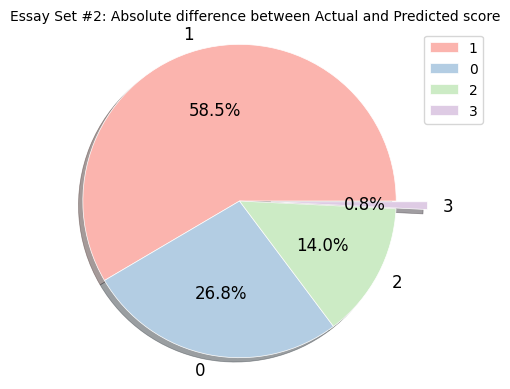

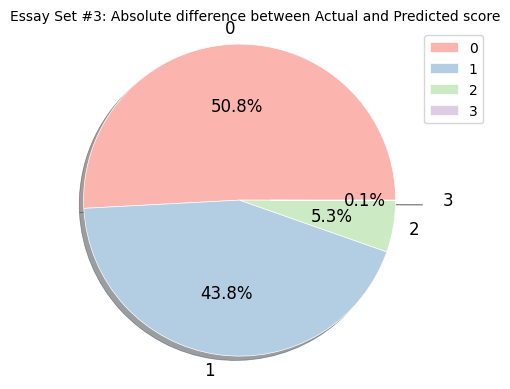

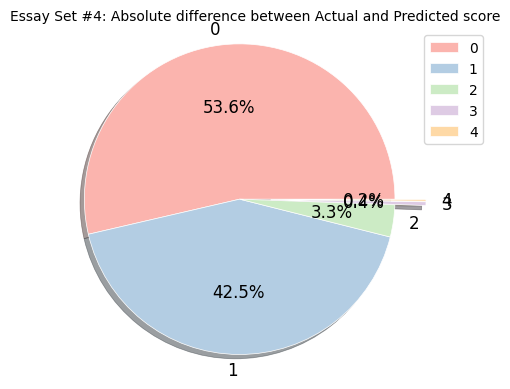

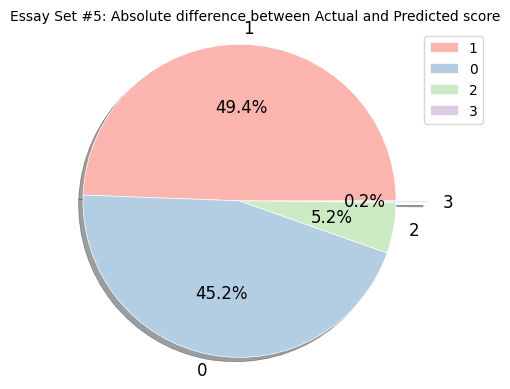

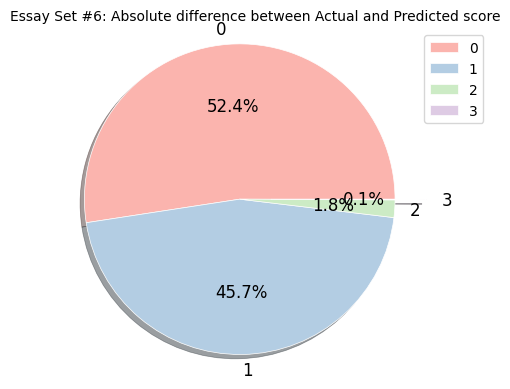

In [14]:
for essay_id in essay_ids:
    df = read_set(essay_id)
    for domain in domains:
        if domain+'_Score_gemini' in df.columns:
            if 'domain1_Point_gemini' in df.columns:
                df['domain1_Score_gemini'] = df['domain1_Score_gemini'].fillna(df['domain1_Point_gemini'])
    # # Plot the actual scores as a pie chart in the first subplot
            df.dropna(subset=[domain+'_Score_gemini'], inplace=True)
            df.dropna(subset=[domain+'_score'], inplace=True)
            
            actual_scores = df[domain+'_score'].astype(int)
            predicted_scores = df[domain+'_Score_gemini'].astype(int)
            m_predicted_scores = [score//4 if score > 6 else score for score in predicted_scores]
            difference = abs(actual_scores-m_predicted_scores)
            # domain = "Language Convensions"
            title = f"Essay Set #{essay_id}: Absolute difference between Actual and Predicted score"
            graph_path = data_path+"reports_graphs_gemini/Pie_EssaySet"+str(essay_id)+"_"+domain+"_"


            create_pie_chart(title, difference, graph_path=graph_path)

# Plot Subgraphs

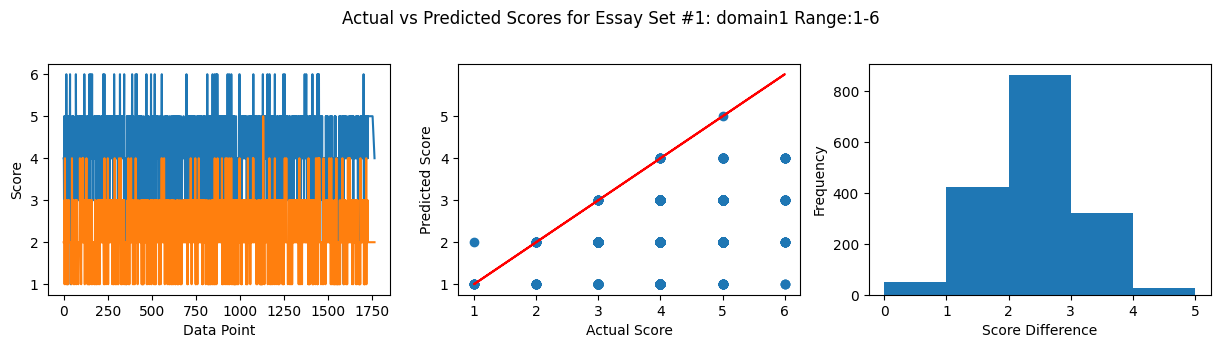

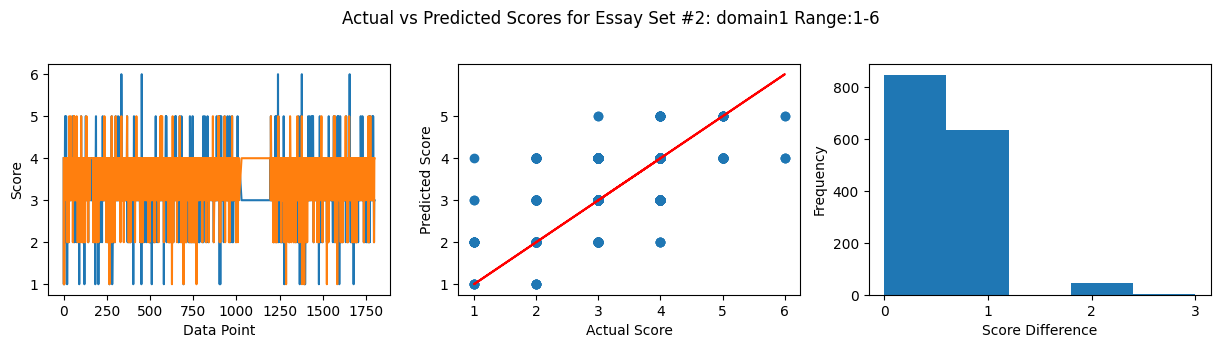

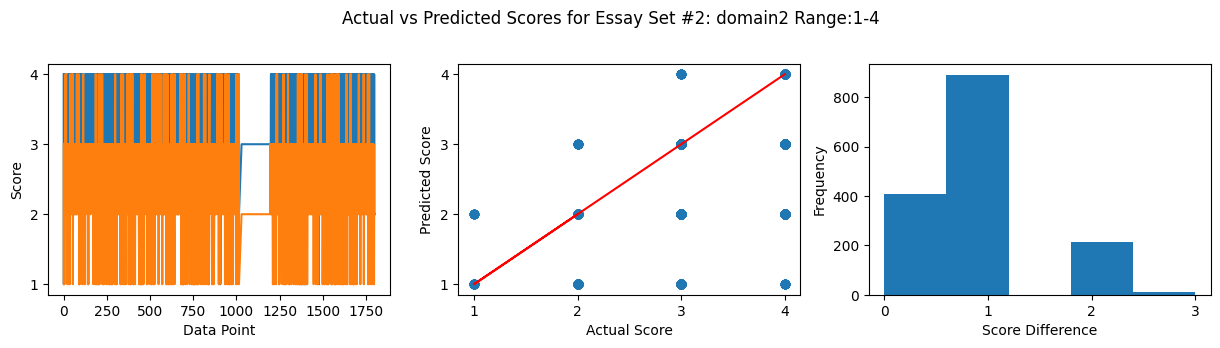

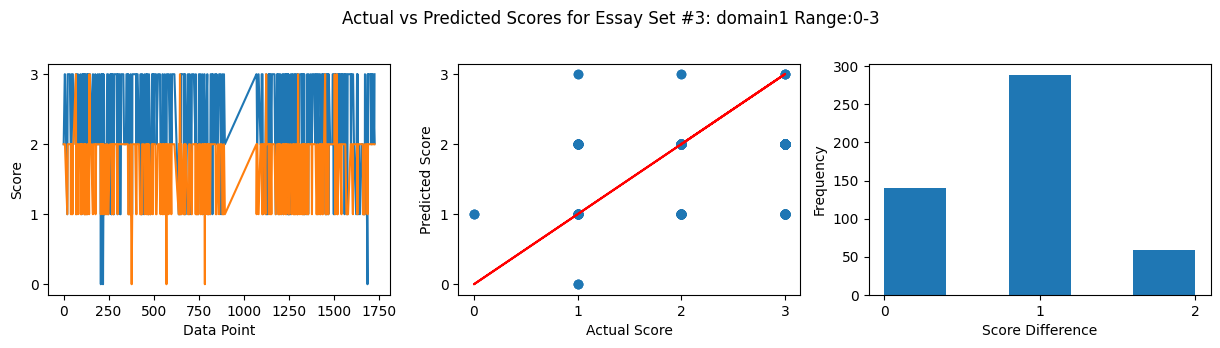

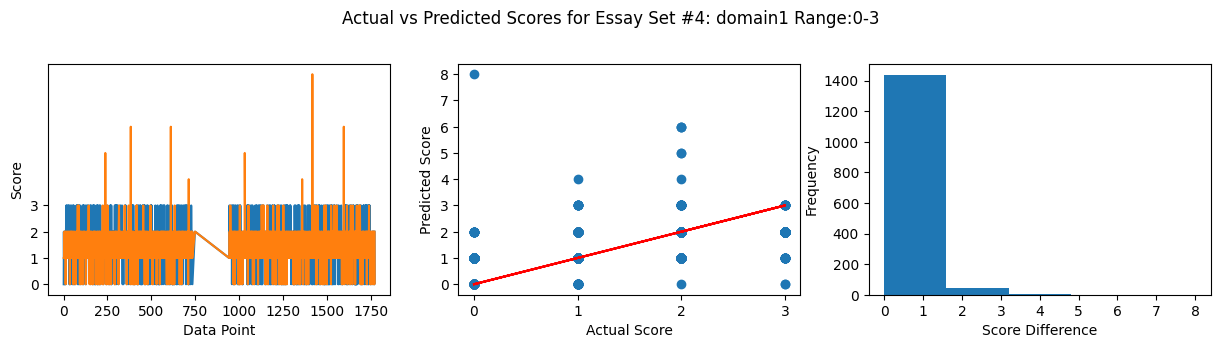

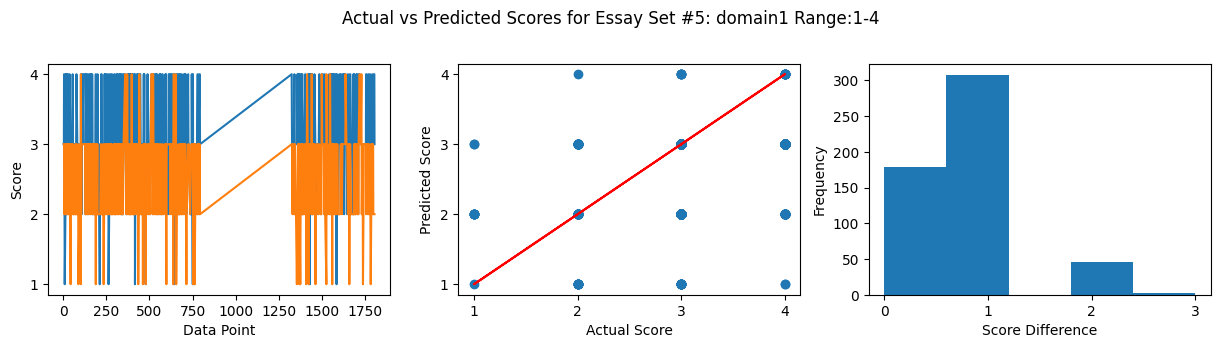

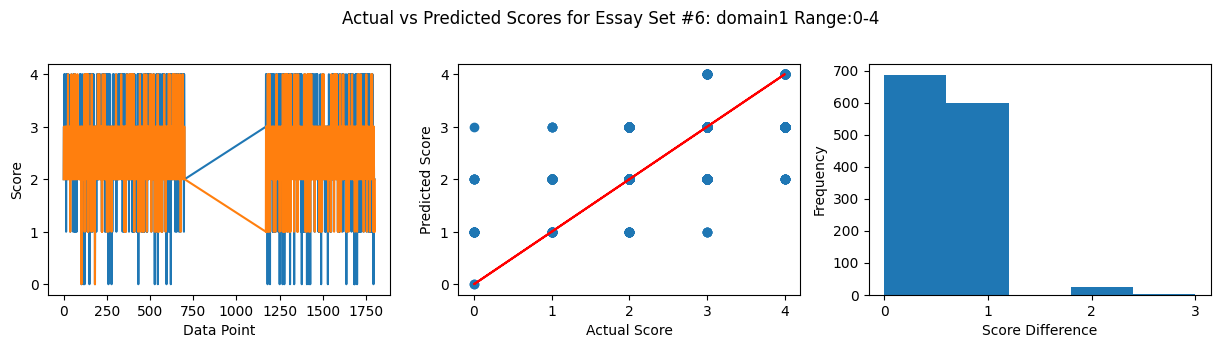

In [11]:
# Draw subplots
for essay_id in essay_ids:
    df = read_set(essay_id)
    for domain in domains:
    # # Plot the actual scores as a pie chart in the first subplot
        if domain+'_score' in df.columns:
            df.dropna(subset=[domain+'_Score_gemini'], inplace=True)
            actual_scores = df[domain+'_score']
            predicted_scores = df[domain+'_Score_gemini']
            difference = abs(actual_scores-predicted_scores)

            # domain = "Language Convensions"
            title = f"Actual vs Predicted Scores for Essay Set #{essay_id}: {domain} Range:{int(actual_scores.min())}-{int(actual_scores.max())}"
            graph_path = data_path+"reports_graphs_gemini/EssaySet"+str(essay_id)+"_"+domain+"_"
            # Create a figure with three subplots

            # Create a figure with three subplots
            fig, axs = plt.subplots(1, 3, figsize=(15,3))
            axs[0].plot(actual_scores, label='Actual Score')
            axs[0].plot(predicted_scores, label='Predicted Score')
            axs[0].set_xlabel('Data Point')
            axs[0].set_ylabel('Score')
            axs[0].set_yticks(range(int(actual_scores.min()), int(actual_scores.max()+1)))
            # axs[1].set_title(title)

            axs[1].scatter(actual_scores, predicted_scores)
            axs[1].plot(actual_scores, actual_scores, color='red')
            axs[1].set_xlabel('Actual Score')
            axs[1].set_xticks(range(int(actual_scores.min()), int(actual_scores.max()+1)))
            axs[1].set_ylabel('Predicted Score')
            axs[1].set_yticks(range(int(predicted_scores.min()), int(predicted_scores.max()+1)))

            
            axs[2].hist(difference, bins=5)
            # Add labels and title
            axs[2].set_xlabel('Score Difference')
            axs[2].set_ylabel('Frequency')
            # plt.xlim(left=0, right=5)
            # axs[0].set_title(title)
            axs[2].set_xticks(range(int(difference.min()), int(difference.max()+1)))
            # Set a title for the whole figure
            fig.suptitle(title, y= 1.06)
            plt.savefig(graph_path+".png", bbox_inches='tight')
            # Display the plot
            plt.show()


# Code for Pearson and Spearman's rank

In [12]:
# Code for Graph plot
def plot_pearson(actual_scores, predicted_scores, title, graph_path):
    corr, pval = pearsonr(actual_scores, predicted_scores)
    # Assuming actual_scores and predicted_scores are NumPy arrays or Python lists containing the actual and predicted scores, respectively
    scorr, spval = spearmanr(actual_scores, predicted_scores)
    print(f"Spearman's rank correlation coefficient: {scorr:.2f}")
    # print the correlation coefficient and p-value
    print("Pearson correlation coefficient: {:.2f}".format(corr))
    print("p-value: {:.3f}".format(pval))

    # plot the data and the linear regression line
    plt.figure(figsize=(5,4))
    plt.tight_layout()
    plt.scatter(actual_scores, predicted_scores)
    plt.plot(actual_scores, actual_scores, color='red')
    plt.title(f"{title}, Pearson correlation coefficient= {corr:.2f}", fontsize=10)
    plt.xlabel('Actual Score')
    plt.xticks(range(int(actual_scores.min()), int(actual_scores.max()+1)))
    plt.ylabel('Predicted Score')
    plt.yticks(range(int(predicted_scores.min()), int(predicted_scores.max()+1)))
    # plt.figure(figsize=(8,3))
    plt.savefig(graph_path+"pearson.png")
    # Display the plot
    plt.show()


## Graphs using loop

1685
1685
Essay Set #1: domain1
Spearman's rank correlation coefficient: 0.42
Pearson correlation coefficient: 0.42
p-value: 0.000


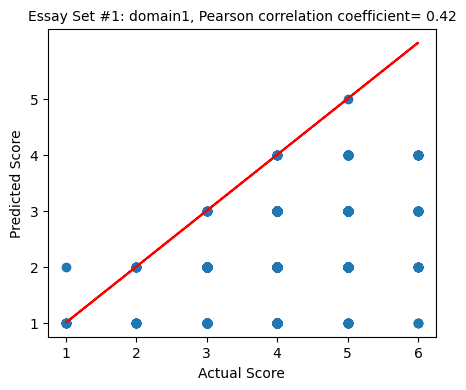

1525
1525
Essay Set #2: domain1
Spearman's rank correlation coefficient: 0.49
Pearson correlation coefficient: 0.55
p-value: 0.000


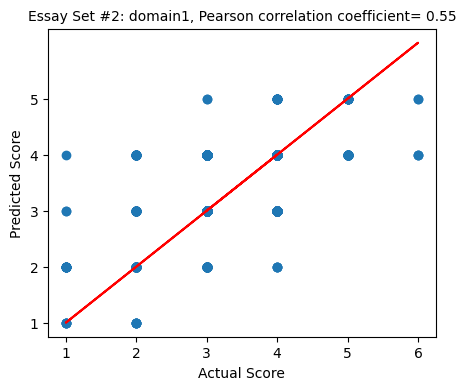

1524
1524
Essay Set #2: domain2
Spearman's rank correlation coefficient: 0.58
Pearson correlation coefficient: 0.58
p-value: 0.000


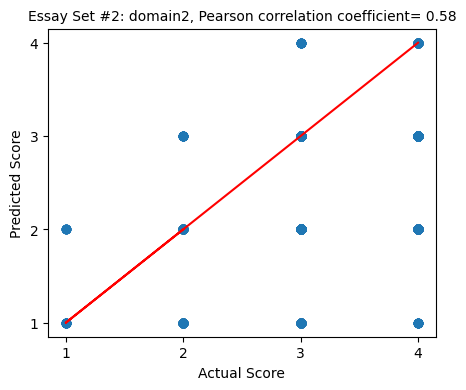

488
488
Essay Set #3: domain1
Spearman's rank correlation coefficient: 0.23
Pearson correlation coefficient: 0.25
p-value: 0.000


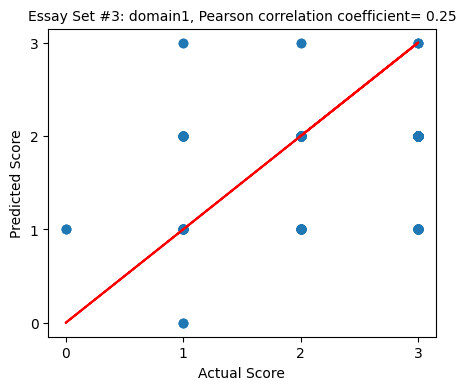

1487
1487
Essay Set #4: domain1
Spearman's rank correlation coefficient: 0.67
Pearson correlation coefficient: 0.59
p-value: 0.000


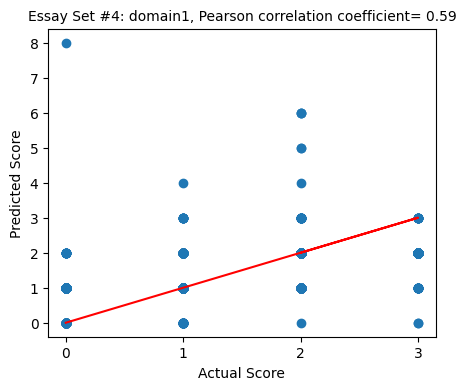

535
535
Essay Set #5: domain1
Spearman's rank correlation coefficient: 0.36
Pearson correlation coefficient: 0.35
p-value: 0.000


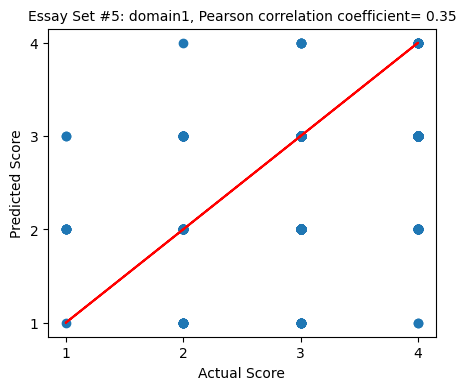

1311
1311
Essay Set #6: domain1
Spearman's rank correlation coefficient: 0.62
Pearson correlation coefficient: 0.66
p-value: 0.000


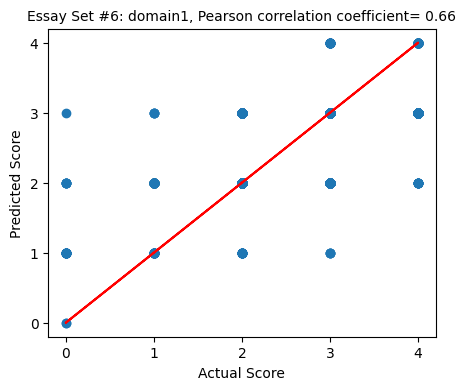

In [13]:
for essay_id in essay_ids:
    df = read_set(essay_id)
    for domain in domains:
        # domain = "Language Convensions"
        # Extract the actual and predicted scores as NumPy arrays
        if domain+'_Score_gemini' in df.columns:
            df.dropna(subset=[domain+'_Score_gemini'], inplace=True)
            df.dropna(subset=[domain+'_score'], inplace=True)
            print(len(df))
            print(len(df))
            title = "Essay Set #"+str(essay_id)+": "+domain
            print("Essay Set #"+str(essay_id)+": "+domain)    
            graph_path = data_path+"reports_graphs_gemini/EssaySet"+str(essay_id)+"_"+domain+"_"
            actual_scores = df[domain+'_score']
            predicted_scores = df[domain+'_Score_gemini']
            # Create a scatter plot of the actual vs predicted scores
            plot_pearson(actual_scores, predicted_scores, title, graph_path)

# code RMSE graph

In [10]:
def plot_rmse(actual_scores, predicted_scores, title, graph_path):
    # Calculate RMSE
    rmse = np.sqrt(np.mean((np.array(predicted_scores) - np.array(actual_scores))**2))
    plt.figure(figsize=(5,4))
    # Create scatter plot
    plt.scatter(actual_scores, predicted_scores, color='blue')

    # Add diagonal line of perfect prediction
    plt.plot([0, 5], [0, 5], color='red')

    # Add RMSE line
    plt.axhline(y=rmse, color='green')

    # Add labels and title
    plt.xlabel('Actual Scores')
    plt.xticks(range(int(actual_scores.min()), int(actual_scores.max()+1)))
    plt.yticks(range(int(predicted_scores.min()), int(predicted_scores.max()+1)))
    # plt.figure(figsize=(8,3))
    plt.ylabel('Predicted Scores')
    plt.title(f'{title}, RMSE = {rmse:.2f}', fontsize=10)
    plt.savefig(graph_path+"rmse.png")

    # Show plot
    plt.show()

## Graphs using loop

Essay Set #1: domain1


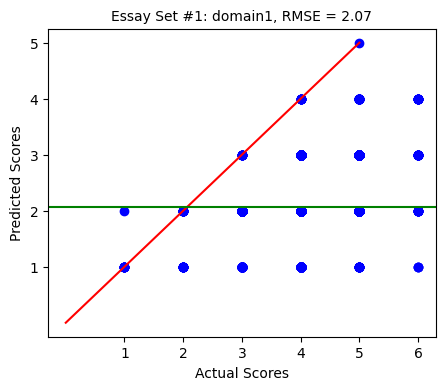

Essay Set #2: domain1


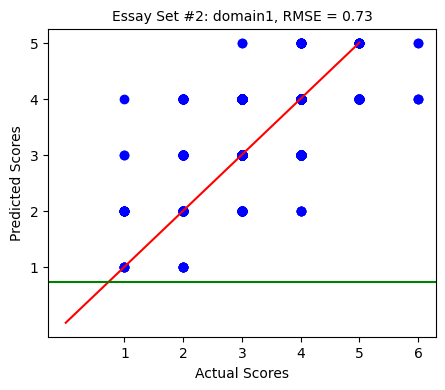

Essay Set #2: domain2


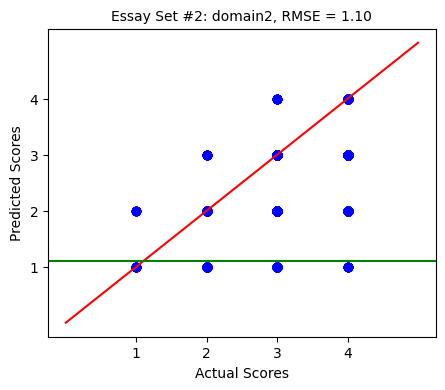

Essay Set #3: domain1


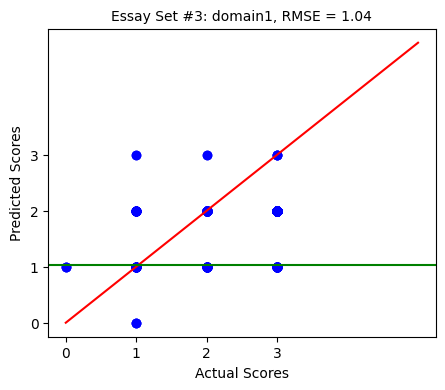

Essay Set #4: domain1


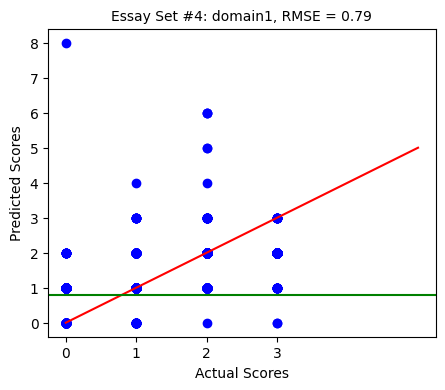

Essay Set #5: domain1


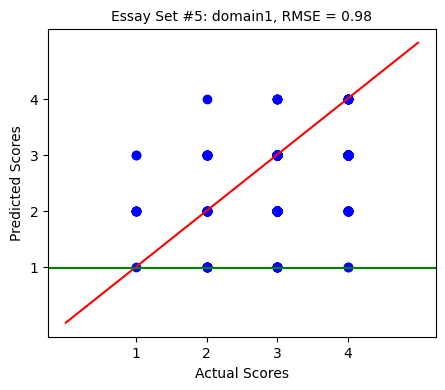

Essay Set #6: domain1


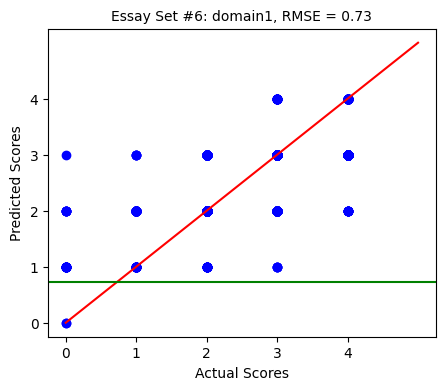

In [11]:
for essay_id in essay_ids:
    df = read_set(essay_id)
    for domain in domains:
        # domain = "Language Convensions"
        # Extract the actual and predicted scores as NumPy arrays
        if domain+'_Score_gemini' in df.columns:
            df.dropna(subset=[domain+'_Score_gemini'], inplace=True)
            df.dropna(subset=[domain+'_score'], inplace=True)
            title = "Essay Set #"+str(essay_id)+": "+domain
            print("Essay Set #"+str(essay_id)+": "+domain)
            
            graph_path = data_path+"reports_graphs_gemini/EssaySet"+str(essay_id)+"_"+domain+"_"
            actual_scores = df[domain+'_score']
            # print(actual_scores)
            predicted_scores = df[domain+'_Score_gemini']
            # Create a scatter plot of the actual vs predicted scores
            plot_rmse(actual_scores, predicted_scores, title, graph_path)

# Code for Box plot

In [12]:
def plot_box(actual_scores, predicted_scores, title, graph_path):
    plt.figure(figsize=(5,4))
    # Create a box plot for the scores
    plt.boxplot([actual_scores, predicted_scores], labels=['Actual', 'Predicted'])

    # Label the axes and add a title
    plt.xlabel('Scores')
    plt.ylabel('Score Scale')
    plt.title(title , fontsize=10)

    # Display the plot
    plt.show()


Essay Set #1: domain1


C:\Users\Nimra\AppData\Local\Temp\ipykernel_8980\651680679.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([actual_scores, predicted_scores], labels=['Actual', 'Predicted'])


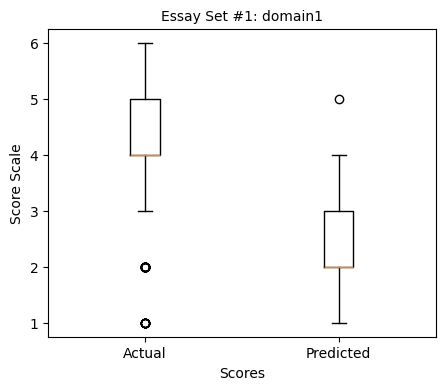

Essay Set #2: domain1


C:\Users\Nimra\AppData\Local\Temp\ipykernel_8980\651680679.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([actual_scores, predicted_scores], labels=['Actual', 'Predicted'])


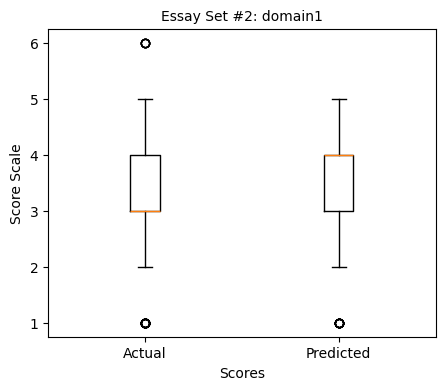

Essay Set #2: domain2


C:\Users\Nimra\AppData\Local\Temp\ipykernel_8980\651680679.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([actual_scores, predicted_scores], labels=['Actual', 'Predicted'])


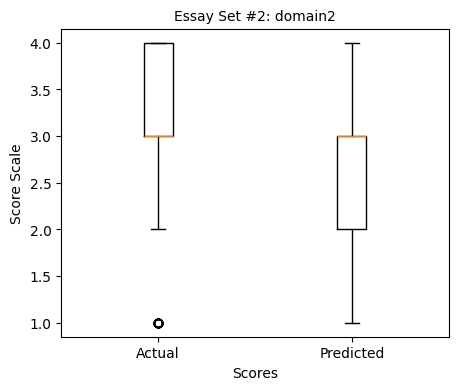

C:\Users\Nimra\AppData\Local\Temp\ipykernel_8980\651680679.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([actual_scores, predicted_scores], labels=['Actual', 'Predicted'])


Essay Set #3: domain1


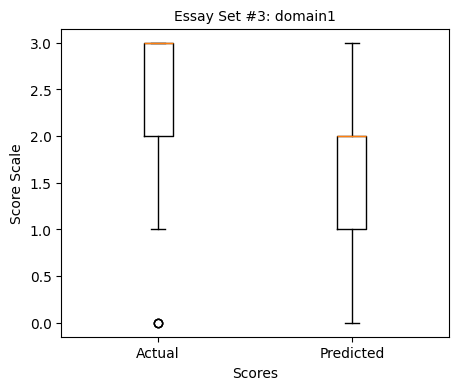

Essay Set #4: domain1


C:\Users\Nimra\AppData\Local\Temp\ipykernel_8980\651680679.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([actual_scores, predicted_scores], labels=['Actual', 'Predicted'])


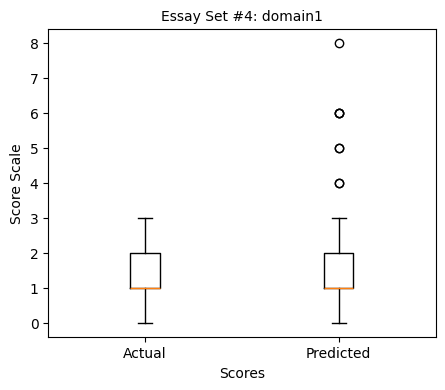

Essay Set #5: domain1


C:\Users\Nimra\AppData\Local\Temp\ipykernel_8980\651680679.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([actual_scores, predicted_scores], labels=['Actual', 'Predicted'])


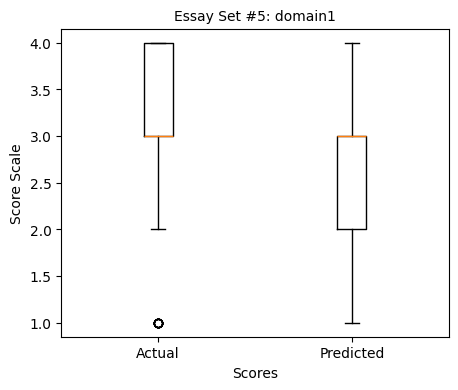

Essay Set #6: domain1


C:\Users\Nimra\AppData\Local\Temp\ipykernel_8980\651680679.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([actual_scores, predicted_scores], labels=['Actual', 'Predicted'])


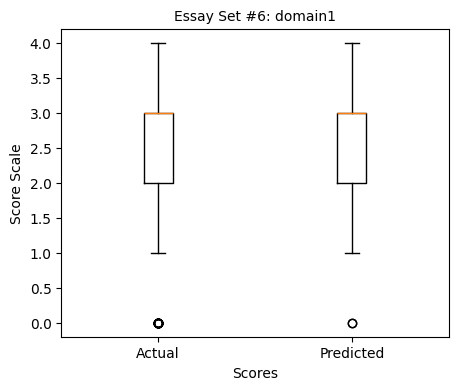

In [13]:
for essay_id in essay_ids:
    df = read_set(essay_id)
    for domain in domains:
        # domain = "Language Convensions"
        # Extract the actual and predicted scores as NumPy arrays
        if domain+'_Score_gemini' in df.columns:
            df.dropna(subset=[domain+'_Score_gemini'], inplace=True)
            df.dropna(subset=[domain+'_score'], inplace=True)
            title = "Essay Set #"+str(essay_id)+": "+domain
            print("Essay Set #"+str(essay_id)+": "+domain)
            
            graph_path = data_path+"reports_graphs_gemini/EssaySet"+str(essay_id)+"_"+domain+"_"
            actual_scores = df[domain+'_score']
            
            predicted_scores = df[domain+'_Score_gemini']
            # Create a box plot
            plot_box(actual_scores, predicted_scores, title, graph_path)

# Other Graphs

In [14]:

# Create a line plot of actual and predicted scores
def plot_line(actual_scores, predicted_scores, title, graph_path):
    plt.figure(figsize=(5,4))
    plt.plot(actual_scores, label='Actual Score')
    plt.plot(predicted_scores, label='Predicted Score')
    plt.xlabel('Data Point')
    plt.ylabel('Score')
    plt.yticks(range(int(actual_scores.min()), int(actual_scores.max()+1)))
    plt.title(title, fontsize=10)
    plt.legend()
    # Adjust the plot layout to prevent labels from overlapping with the border
    plt.tight_layout()
    plt.savefig(graph_path+"line.png")
    plt.show()
# Create a histogram of the differences


def plot_bar(actual_scores, predicted_scores, title, graph_path):
    difference = abs(actual_scores-predicted_scores)
    # print(len(df['Score Difference']))
    plt.figure(figsize=(5,4))
    n, bins, patches = plt.hist(difference, bins=5)
    # Add labels and title
    plt.xlabel('Score Difference')
    plt.ylabel('Frequency')
    # plt.xlim(left=0, right=5)
    plt.title(title, fontsize=10)
    plt.tight_layout()
    plt.xticks(range(int(difference.min()), int(difference.max()+1)))
    for i in range(len(patches)):
        plt.annotate(str(int(n[i])), xy=(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height()),
                 xytext=(0, 7), textcoords='offset points', ha='center', va='bottom')
    # Show the plot
    # Adjust the plot layout to prevent labels from overlapping with the border
    # plt.gca().invert_yaxis()
    # Adjust the plot layout to prevent labels from overlapping with the border
    plt.savefig(graph_path+"bar.png")
    plt.show()

Essay Set #1: domain1


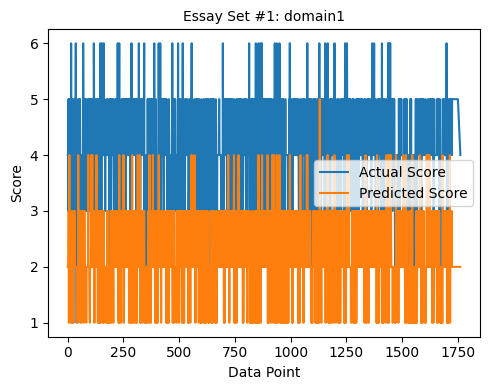

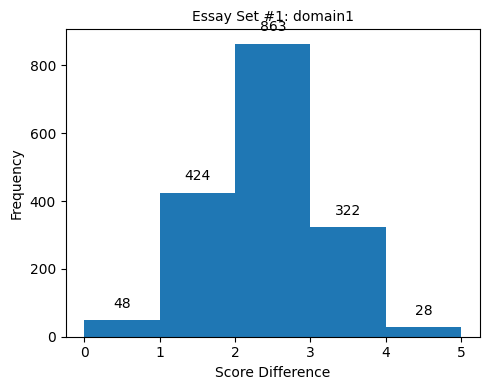

Essay Set #2: domain1


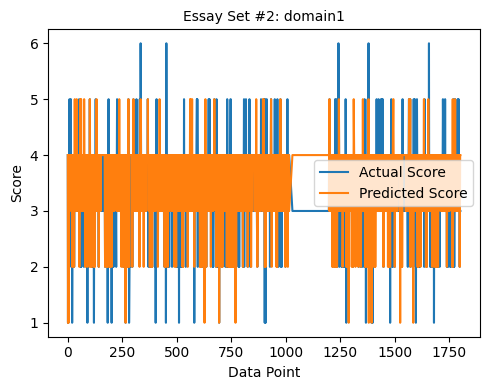

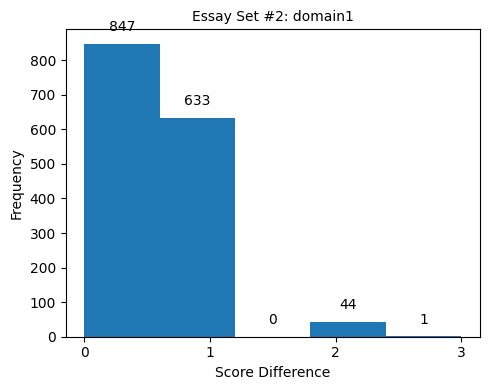

Essay Set #2: domain2


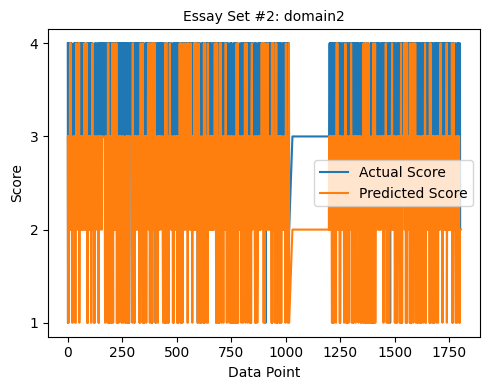

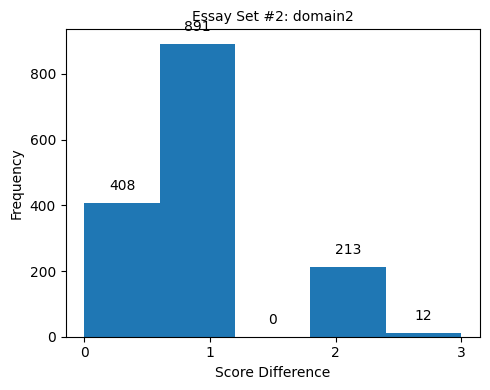

Essay Set #3: domain1


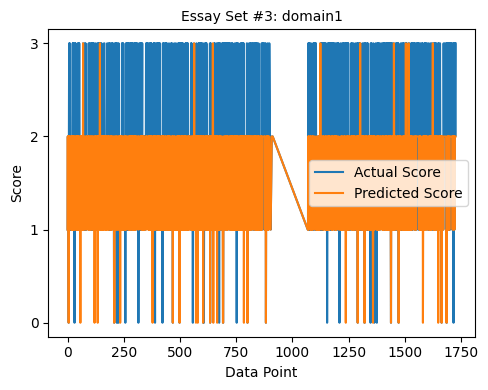

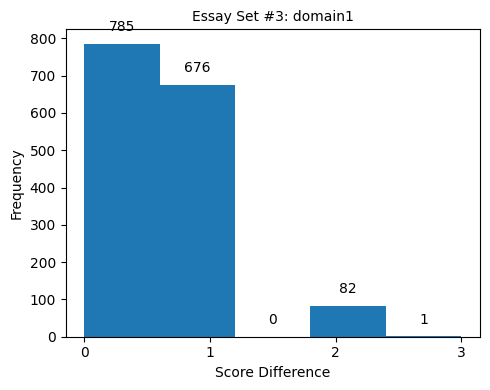

Essay Set #4: domain1


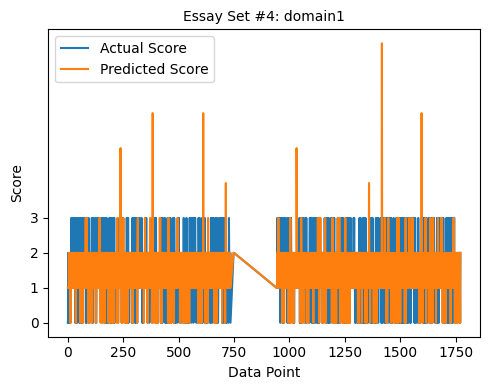

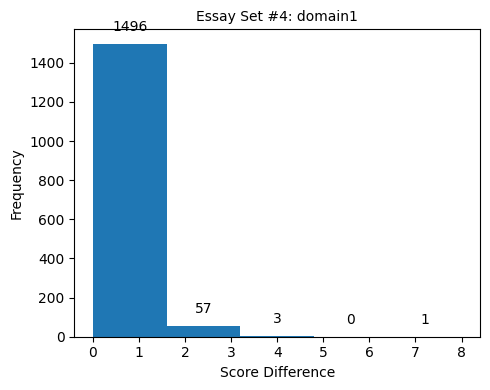

Essay Set #5: domain1


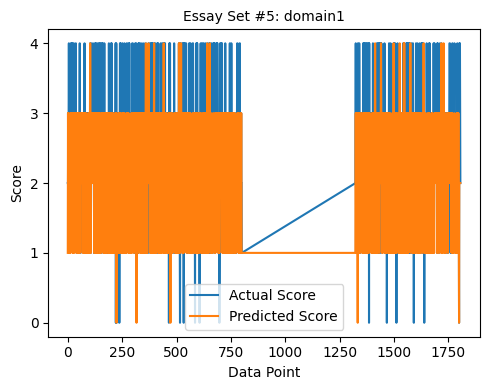

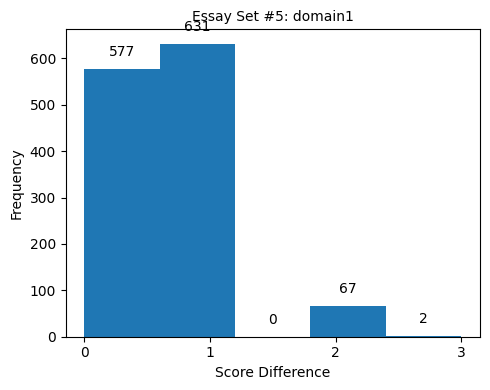

Essay Set #6: domain1


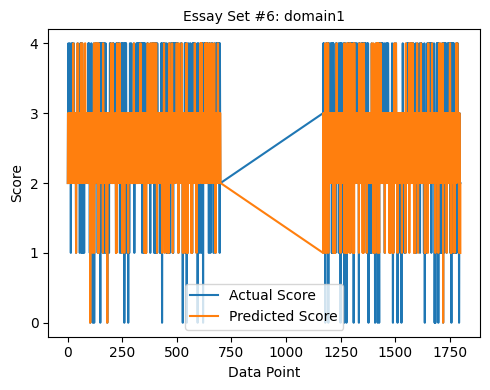

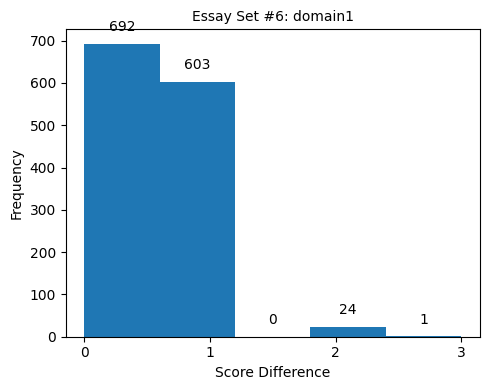

In [15]:
for essay_id in essay_ids:
    df = read_set(essay_id)
    for domain in domains:
        # domain = "Language Convensions"
        # Extract the actual and predicted scores as NumPy arrays
        if domain+'_Score_gemini' in df.columns:
            if domain+'_Point_gemini' in df.columns:
                df[domain+'_Score_gemini'] = df[domain+'_Score_gemini'].fillna(df[domain+'_Point_gemini'])
            df.dropna(subset=[domain+'_Score_gemini'], inplace=True)
            df.dropna(subset=[domain+'_score'], inplace=True)
            title = "Essay Set #"+str(essay_id)+": "+domain
            print("Essay Set #"+str(essay_id)+": "+domain)
            
            graph_path = data_path+"reports_graphs_gemini/EssaySet"+str(essay_id)+"_"+domain+"_"
            actual_scores = df[domain+'_score']
            # print(actual_scores)
            predicted_scores = df[domain+'_Score_gemini']
            plot_line(actual_scores, predicted_scores, title, graph_path)
            plot_bar(actual_scores, predicted_scores, title, graph_path)